<a href="https://colab.research.google.com/github/asarria48/Nuclear-physics/blob/main/Informe4IN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Coeficientes de calibración

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from datetime import datetime
import os

<>:13: SyntaxWarning: invalid escape sequence '\g'
<>:13: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3394190180.py:13: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel("$I_\gamma$ [cuentas/canal]", fontsize=14)


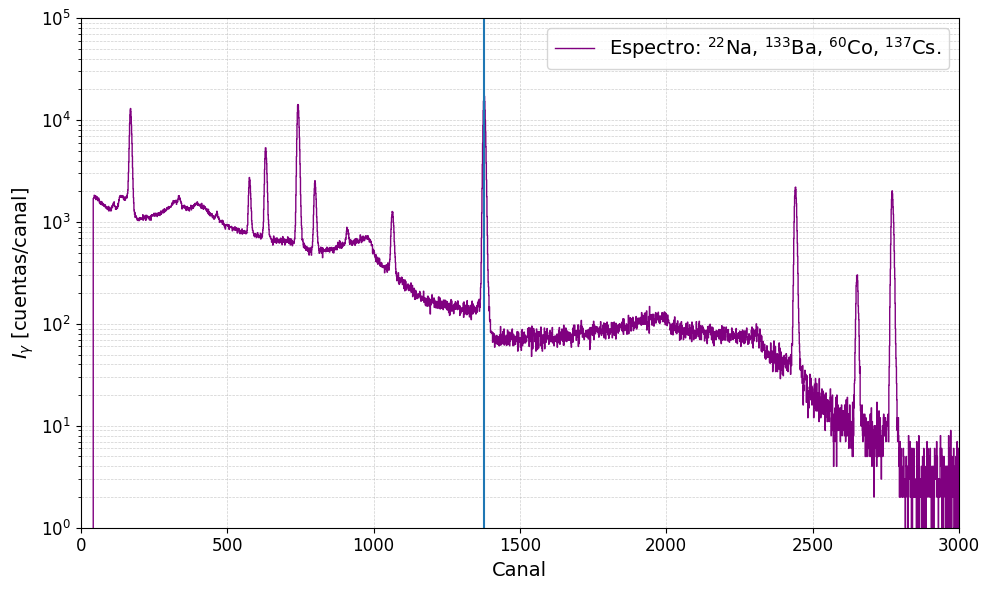

In [71]:
datos = "2021-11-15_cal_133Ba22Na137Cs60Co_600s_1.csv"
df = pd.read_csv(datos)

x = df.iloc[:, 0]
y = df.iloc[:, 1]

plt.figure(figsize=(10,6))
plt.plot(x, y, color='purple', ds="steps-mid", lw=1, label="Espectro: $^{22}$Na, $^{133}$Ba, $^{60}$Co, $^{137}$Cs.")
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.yscale('log')
plt.xlabel("Canal", fontsize=14)
plt.ylabel("$I_\gamma$ [cuentas/canal]", fontsize=14)
plt.grid(which="both", linestyle="--", linewidth=0.5, alpha=0.6)
plt.xlim(0,3000)
plt.ylim(1e0, 1e5)

plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


Hay algunos picos que ya identifico, puedo usarlos para hacer un ajuste preliminar y ubicar los otros

In [117]:

def gauss_bg(x, mu, sigma, A, a0, a1):                                          # gaussiana con fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x

def fwhm(sigma): return 2.3458 * sigma
def dfwhm(dsigma): return 2.3458 * dsigma
def intensidad(A, sigma): return A * sigma * np.sqrt(2*np.pi)
def dintensidad(A, sigma, dA, dsigma):
    return np.sqrt((sigma*np.sqrt(2*np.pi)*dA)**2 + (A*np.sqrt(2*np.pi)*dsigma)**2)

def format_unc(value, error):
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"


# ajustes en general
def ajustar_pico(x, y, x_min, x_max, color="purple"):

    mask = (x >= x_min) & (x <= x_max)
    xr, yr = x[mask], y[mask]

    mu_guess = xr.iloc[np.argmax(yr)]
    A_guess = yr.max()
    p0 = [mu_guess, 4.0, A_guess, np.median(yr), 0.0]

    popt, pcov = curve_fit(gauss_bg, xr, yr, p0=p0, maxfev=10000)
    perr = np.sqrt(np.diag(pcov))

    mu, sigma, A, a0, a1 = popt
    dmu, dsigma, dA, da0, da1 = perr

    print(f"\n======")
    labels = ["μ", "σ", "FWHM", "Int"]
    vals   = [mu, sigma, fwhm(sigma), intensidad(A, sigma)]
    errs   = [dmu, dsigma, dfwhm(dsigma), dintensidad(A, sigma, dA, dsigma)]

    for l, v, e in zip(labels, vals, errs):
        print(f"{l:8s} = {format_unc(v, e)}")

    xf = np.linspace(xr.min(), xr.max(), 800)
    fit = gauss_bg(xf, *popt)
    bg  = a0 + a1 * xf

    # gráficas

    '''Descomentar si quiere ver los ajustes preliminares'''
    # fig, ax = plt.subplots(figsize=(6, 4))
    # ax.step(xr, yr, where='mid', color='black', lw=0.8)
    # ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    # ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    # ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)

    # ax.set_xlabel("Canal", fontsize=14)
    # ax.set_ylabel("$I_\gamma$ [cuentas/canal]", fontsize=14)
    # ax.legend(fontsize=12)
    # ax.grid(alpha=0.3)


    # plt.tight_layout()
    # plt.show()


# ajusto varios picos de una vez

datos = "2021-11-15_cal_133Ba22Na137Cs60Co_600s_1.csv"
df = pd.read_csv(datos)

x = df.iloc[:, 0]
y = df.iloc[:, 1]

# plt.axvline(1379)
# plt.axvline(2442)
# plt.axvline(2651)
# plt.axvline(2770)

picos = [
    (1365, 1392, "purple"),                                                     # del cesio 137 (no el pico de rayos X) 661 keV
    (2430, 2455, "purple"),                                                     # del cobalto 60 (primero) 1173 keV
    (2630, 2670, "purple"),                                                     # del cobalto 60 (segundo) 1332 keV
    (2755, 2790, "purple"),                                                     # del sodio 22, 1275 keV
]

for xmin, xmax, color in picos:
    ajustar_pico(x, y, xmin, xmax, color)



μ        = 1378.142(49)
σ        = 3.549(58)
FWHM     = 8.32(14)
Int      = 155394(32)

μ        = 2441.608(53)
σ        = 3.709(66)
FWHM     = 8.70(15)
Int      = 20008(43)

μ        = 2652.062(66)
σ        = 3.606(73)
FWHM     = 8.46(17)
Int      = 2621(68)

μ        = 2772.424(73)
σ        = 3.743(82)
FWHM     = 8.78(19)
Int      = 17929(50)


Ajuste preliminar

In [116]:

E = np.array([661.7, 1173.2, 1274.5, 1332.5])
mu = np.array([1378.142, 2441.608, 2652.062, 2772.424])
dmu = np.array([0.049, 0.053, 0.066, 0.073])
dE = np.ones_like(E)


def f(E, b0, b1):
    return b0 + b1 * E                                                                                # canal = b0 + b1 * energía

popt, pcov = curve_fit(f, E, mu, sigma=dE, absolute_sigma=True)
b0, b1 = popt
db0, db1 = np.sqrt(np.diag(pcov))

print("=== Ajuste de canal vs energía ===")
print(f"b0 = {b0:.3f} ± {db0:.3f}")
print(f"b1 = {b1:.5f} ± {db1:.5f}")
print(pcov[0,1])

# invierto
# E = a0 + a1 * canal
a1 = 1 / b1
a0 = -b0 / b1
da1 = db1 / b1**2
da0 = np.sqrt((db0/b1)**2 + (b0*db1/b1**2)**2)


def format_uncertainty(value, uncertainty):
    n_decimals = int(-np.floor(np.log10(uncertainty))) + 1
    value_rounded = round(value, n_decimals)
    uncertainty_rounded = round(uncertainty, n_decimals)
    digits = str(uncertainty_rounded).replace('.', '')[:3]
    return f"{value_rounded:.{n_decimals}f}({digits})"

a0_str = format_uncertainty(a0, da0)
a1_str = format_uncertainty(a1, da1)

print("\n=== Resultados de la calibración en energía ===")
print(f"a0 = {a0_str} keV")
print(f"a1 = {a1_str} keV/canal")
print(f"\nEcuación de calibración:")
print(f"E = {a0_str} + {a1_str} * canal")
print(f"Acomodar la incertidumbre de a0 a (2) y despreciar la de a1.")

'''Descomentar si quiere ver el ajuste preliminar'''
# plt.figure(figsize=(10,5))
# plt.errorbar(mu, E, xerr=dmu, fmt='o', color='black', capsize=3, label='Datos')
# plt.plot(mu, a0 + a1*mu, color='green', lw=1, label='Ajuste lineal')
# plt.xlabel('Canal', fontsize=14)
# plt.ylabel('$E_{\\gamma}$ [keV]', fontsize=14)
# plt.legend(fontsize=14)
# plt.grid(True, ls='--', alpha=0.6)
# plt.tight_layout()
# plt.show()


E_ajustado = a0 + a1 * mu
dif = E - E_ajustado
error_rel = np.abs(dif / E) * 100

# print("\n=== Comparación Energía Teórica vs Ajustada ===")
# print(f"{'Canal':>8} {'E_teórico (keV)':>18} {'E_ajustado (keV)':>20} {'ΔE (keV)':>12} {'Error %':>10}")
# for i in range(len(E)):
#     print(f"{mu[i]:8.2f} {E[i]:18.3f} {E_ajustado[i]:20.3f} {dif[i]:12.3f} {error_rel[i]:10.3f}")

=== Ajuste de canal vs energía ===
b0 = 2.699 ± 2.152
b1 = 2.07871 ± 0.00188
-0.003944394532152059

=== Resultados de la calibración en energía ===
a0 = -1.3(10) keV
a1 = 0.48107(000) keV/canal

Ecuación de calibración:
E = -1.3(10) + 0.48107(000) * canal
Acomodar la incertidumbre de a0 a (2) y despreciar la de a1.


Con el ajuste preliminar ubico los otros picos del espectro

In [102]:
E = 383.84                            # meto aquí cada energía propuesta en la tabla C.2, recibo alrededor de dónde está el pico y puedo terminar de ubicarlo a ojo. En este caso, me faltan las del Bario 133
Canal = 2.7 + 2.07 * E
print(Canal)

797.2488


<>:13: SyntaxWarning: invalid escape sequence '\g'
<>:13: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-357775269.py:13: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel("$I_\gamma$ [cuentas/canal]", fontsize=14)


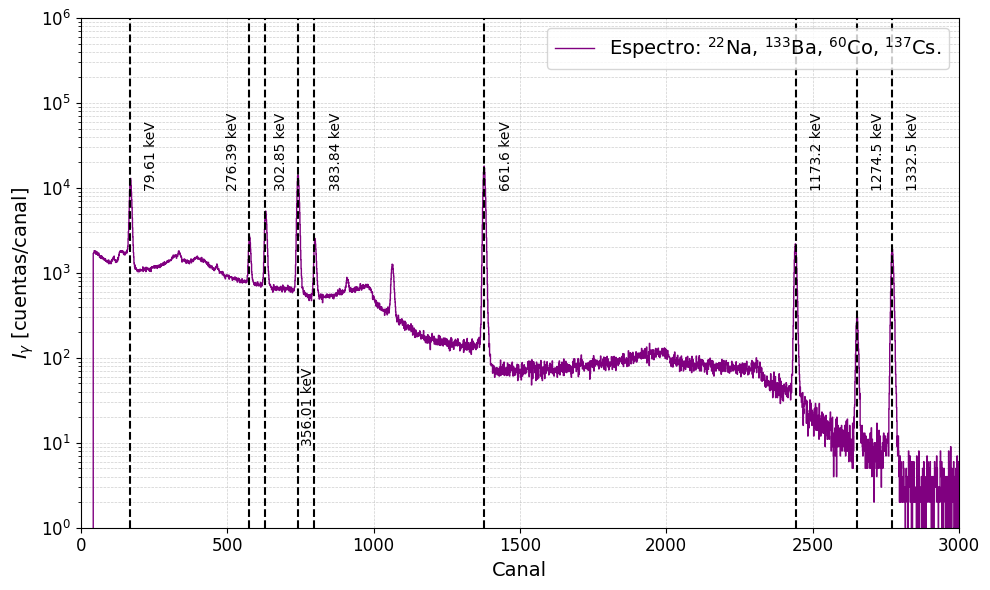

In [114]:
datos = "2021-11-15_cal_133Ba22Na137Cs60Co_600s_1.csv"
df = pd.read_csv(datos)

x = df.iloc[:, 0]
y = df.iloc[:, 1]

plt.figure(figsize=(10,6))
plt.plot(x, y, color='purple', ds="steps-mid", lw=1, label="Espectro: $^{22}$Na, $^{133}$Ba, $^{60}$Co, $^{137}$Cs.")
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.yscale('log')
plt.xlabel("Canal", fontsize=14)
plt.ylabel("$I_\gamma$ [cuentas/canal]", fontsize=14)
plt.grid(which="both", linestyle="--", linewidth=0.5, alpha=0.6)
plt.xlim(0,3000)
plt.ylim(1e0, 1e6)


# del bario 133

plt.axvline(167.49, color='black', lw=1.5,linestyle='--')
plt.text(167.49+50, 1e4, f'79.61 keV', color='black',rotation=90, fontsize=10)

plt.axvline(574.82, color='black', lw=1.5,linestyle='--')
plt.text(574.82-80, 1e4, f'276.39 keV', color='black',rotation=90, fontsize=10)

plt.axvline(629.59, color='black', lw=1.5,linestyle='--')
plt.text(629.59+30, 1e4, f'302.85 keV', color='black',rotation=90, fontsize=10)

plt.axvline(743, color='black', lw=1.5,linestyle='--')
plt.text(743+10, 1e1, f'356.01 keV', color='black',rotation=90, fontsize=10)

plt.axvline(797.24, color='black', lw=1.5,linestyle='--')
plt.text(797.24+50, 1e4, f'383.84 keV', color='black',rotation=90, fontsize=10)

# -------------------------------------------------------------------------------

plt.axvline(1379, color='black', lw=1.5,linestyle='--')
plt.text(1379 + 50, 1e4, f'661.6 keV', color='black',rotation=90, fontsize=10)    # del cesio 137

plt.axvline(2442, color='black', lw=1.5,linestyle='--')
plt.text(2442 + 50, 1e4, f'1173.2 keV', color='black',rotation=90, fontsize=10)   # "primero" del cobalto 60

plt.axvline(2770, color='black', lw=1.5,linestyle='--')
plt.text(2770 + 50, 1e4, f'1332.5 keV', color='black',rotation=90, fontsize=10)   # "segundo" del cobalto 60

plt.axvline(2651, color='black', lw=1.5,linestyle='--')
plt.text(2651 + 50, 1e4, f'1274.5 keV', color='black',rotation=90, fontsize=10)    # del sodio 22

plt.legend(loc='upper right',fontsize=14)
plt.tight_layout()
plt.show()


Ahora sí puedo hacer los ajustes correspondientes y la calibración


μ        = 170.065(45)
σ        = 3.491(52)
FWHM     = 8.19(12)
Int      = 96996(18)


<>:69: SyntaxWarning: invalid escape sequence '\g'
<>:69: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-2917766639.py:69: SyntaxWarning: invalid escape sequence '\g'
  ax.set_ylabel("$I_\gamma$ [cuentas/canal]", fontsize=14)


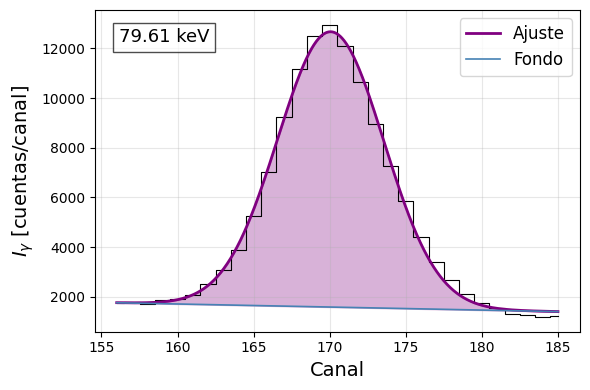


μ        = 576.718(63)
σ        = 3.392(76)
FWHM     = 7.96(18)
Int      = 16106(44)


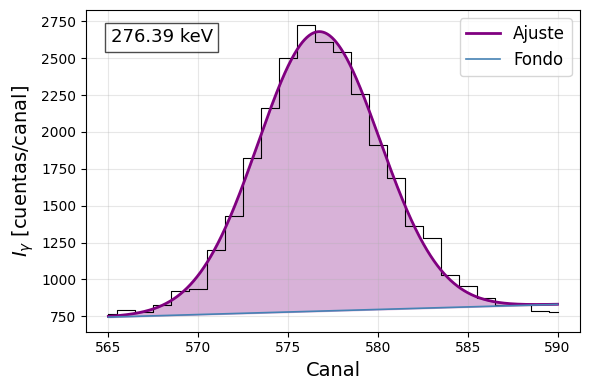


μ        = 631.826(55)
σ        = 3.562(62)
FWHM     = 8.36(14)
Int      = 40542(89)


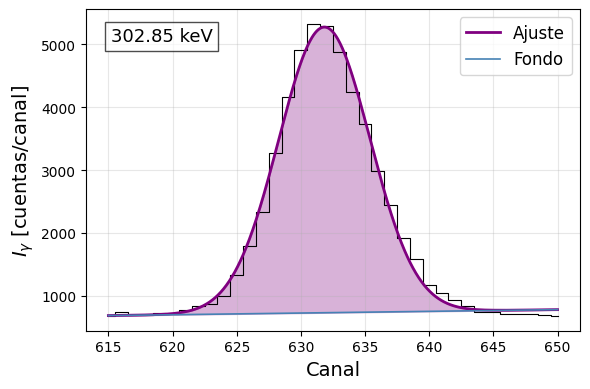


μ        = 742.409(59)
σ        = 3.552(70)
FWHM     = 8.33(16)
Int      = 120064(30)


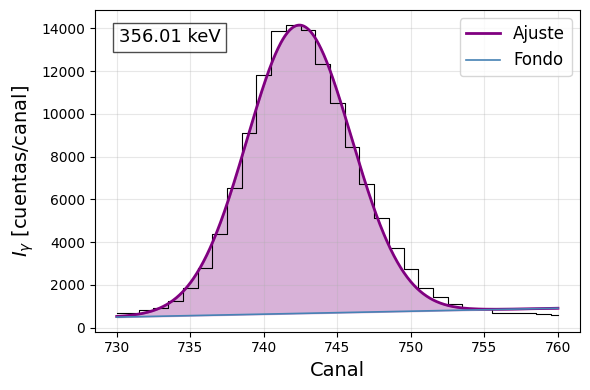


μ        = 800.281(59)
σ        = 3.591(68)
FWHM     = 8.42(16)
Int      = 17257(41)


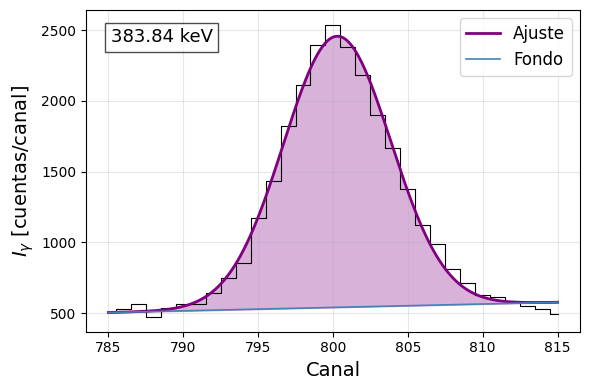


μ        = 1378.142(49)
σ        = 3.549(58)
FWHM     = 8.32(14)
Int      = 155394(32)


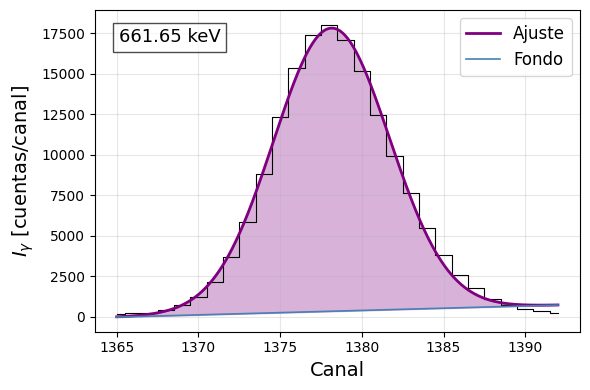


μ        = 2441.608(53)
σ        = 3.709(66)
FWHM     = 8.70(15)
Int      = 20008(43)


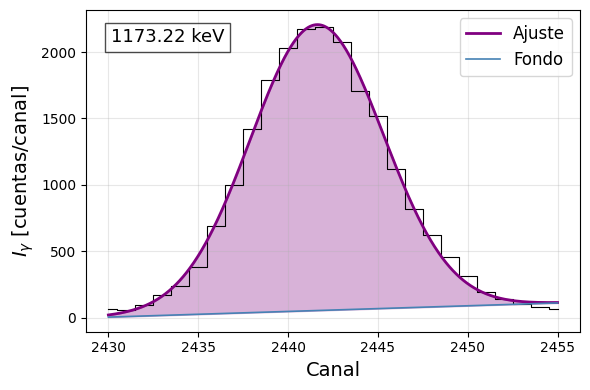


μ        = 2652.062(66)
σ        = 3.606(73)
FWHM     = 8.46(17)
Int      = 2621(68)


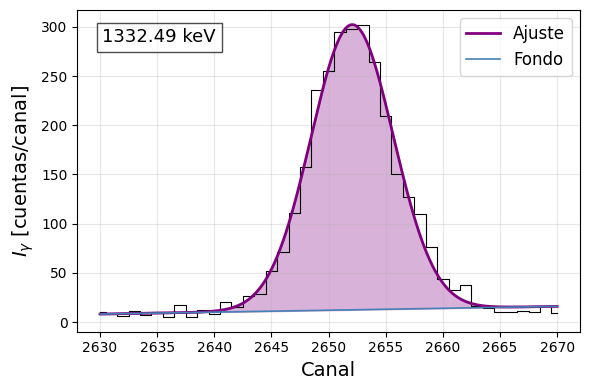


μ        = 2772.424(73)
σ        = 3.743(82)
FWHM     = 8.78(19)
Int      = 17929(50)


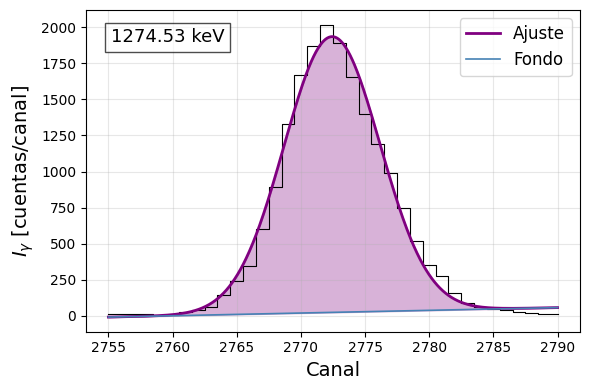

In [142]:

def gauss_bg(x, mu, sigma, A, a0, a1):                                          # gaussiana con fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x

def fwhm(sigma): return 2.3458 * sigma
def dfwhm(dsigma): return 2.3458 * dsigma
def intensidad(A, sigma): return A * sigma * np.sqrt(2*np.pi)
def dintensidad(A, sigma, dA, dsigma):
    return np.sqrt((sigma*np.sqrt(2*np.pi)*dA)**2 + (A*np.sqrt(2*np.pi)*dsigma)**2)

def format_unc(value, error):
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"


# ajustes en general
def ajustar_pico(x, y, x_min, x_max, color="purple", energia_keV=None):

    mask = (x >= x_min) & (x <= x_max)
    xr, yr = x[mask], y[mask]

    mu_guess = xr.iloc[np.argmax(yr)]
    A_guess = yr.max()
    p0 = [mu_guess, 4.0, A_guess, np.median(yr), 0.0]

    popt, pcov = curve_fit(gauss_bg, xr, yr, p0=p0, maxfev=10000)
    perr = np.sqrt(np.diag(pcov))

    mu, sigma, A, a0, a1 = popt
    dmu, dsigma, dA, da0, da1 = perr

    print(f"\n======")
    labels = ["μ", "σ", "FWHM", "Int"]
    vals   = [mu, sigma, fwhm(sigma), intensidad(A, sigma)]
    errs   = [dmu, dsigma, dfwhm(dsigma), dintensidad(A, sigma, dA, dsigma)]

    for l, v, e in zip(labels, vals, errs):
        print(f"{l:8s} = {format_unc(v, e)}")

    xf = np.linspace(xr.min(), xr.max(), 800)
    fit = gauss_bg(xf, *popt)
    bg  = a0 + a1 * xf

    # gráficas
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.step(xr, yr, where='mid', color='black', lw=0.8)
    ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)

    if energia_keV is not None:
     ax.text(
            0.05, 0.90,
            f"{energia_keV:.2f} keV",
            transform=ax.transAxes,
            fontsize=13,
            color="black",
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
        )

    ax.set_xlabel("Canal", fontsize=14)
    ax.set_ylabel("$I_\gamma$ [cuentas/canal]", fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(alpha=0.3)


    plt.tight_layout()
    plt.show()


# ajusto varios picos de una vez

datos = "2021-11-15_cal_133Ba22Na137Cs60Co_600s_1.csv"
df = pd.read_csv(datos)

x = df.iloc[:, 0]
y = df.iloc[:, 1]

picos = [
    (156, 185, "purple", 79.61),                                                        # del bario 133, 79.61 keV
    (565, 590, "purple", 276.39),                                                       # del bario 133, 276.39 keV
    (615, 650, "purple", 302.85),                                                       # del bario 133, 302.85 keV
    (730, 760, "purple", 356.01),                                                       # del bario 133, 356.01 keV
    (785, 815, "purple", 383.84),                                                       # del bario 133, 383.84 keV
    (1365, 1392, "purple", 661.65),                                                     # del cesio 137 (no el pico de rayos X) 661 keV
    (2430, 2455, "purple", 1173.22),                                                    # del cobalto 60 (primero) 1173 keV
    (2630, 2670, "purple", 1332.49),                                                    # del cobalto 60 (segundo) 1332 keV
    (2755, 2790, "purple", 1274.53),                                                    # del sodio 22, 1275 keV
]

for xmin, xmax, color, energia in picos:
    ajustar_pico(x, y, xmin, xmax, color, energia)


Ya con los datos de ajuste, la calibración

=== Ajuste de canal vs energía ===
b0 = 2.932 ± 0.580
b1 = 2.07839 ± 0.00073
-0.0003465908571429609

=== Resultados de la calibración en energía ===
a0 = -1.41(028) keV
a1 = 0.48114(000) keV/canal

Ecuación de calibración:
E = -1.41(028) + 0.48114(000) * canal
Acomodar la incertidumbre de a0 a (3) y despreciar la de a1.


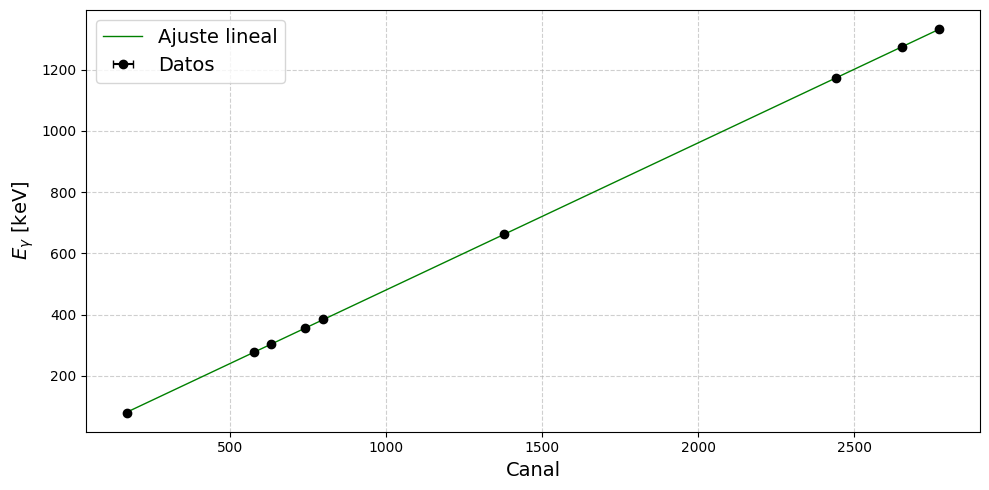

In [146]:

E = np.array([79.6139, 276.3997, 302.8510, 356.0134, 383.8480, 661.657, 1173.228, 1274.537, 1332.490])
mu = np.array([170.065, 576.718, 631.826, 742.409, 800.281, 1378.142, 2441.608, 2652.062, 2772.424])
dmu = np.array([0.045, 0.063, 0.055, 0.059, 0.059, 0.049, 0.053, 0.066, 0.073])
dE = np.ones_like(E)


def f(E, b0, b1):
    return b0 + b1 * E                                                                                # canal = b0 + b1 * energía

popt, pcov = curve_fit(f, E, mu, sigma=dE, absolute_sigma=True)
b0, b1 = popt
db0, db1 = np.sqrt(np.diag(pcov))

print("=== Ajuste de canal vs energía ===")
print(f"b0 = {b0:.3f} ± {db0:.3f}")
print(f"b1 = {b1:.5f} ± {db1:.5f}")
print(pcov[0,1])

# invierto
# E = a0 + a1 * canal
a1 = 1 / b1
a0 = -b0 / b1
da1 = db1 / b1**2
da0 = np.sqrt((db0/b1)**2 + (b0*db1/b1**2)**2)


def format_uncertainty(value, uncertainty):
    n_decimals = int(-np.floor(np.log10(uncertainty))) + 1
    value_rounded = round(value, n_decimals)
    uncertainty_rounded = round(uncertainty, n_decimals)
    digits = str(uncertainty_rounded).replace('.', '')[:3]
    return f"{value_rounded:.{n_decimals}f}({digits})"

a0_str = format_uncertainty(a0, da0)
a1_str = format_uncertainty(a1, da1)

print("\n=== Resultados de la calibración en energía ===")
print(f"a0 = {a0_str} keV")
print(f"a1 = {a1_str} keV/canal")
print(f"\nEcuación de calibración:")
print(f"E = {a0_str} + {a1_str} * canal")
print(f"Acomodar la incertidumbre de a0 a (3) y despreciar la de a1.")


plt.figure(figsize=(10,5))
plt.errorbar(mu, E, xerr=dmu, fmt='o', color='black', capsize=3, label='Datos')
plt.plot(mu, a0 + a1*mu, color='green', lw=1, label='Ajuste lineal')
plt.xlabel('Canal', fontsize=14)
plt.ylabel('$E_{\\gamma}$ [keV]', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, ls='--', alpha=0.6)
plt.tight_layout()
plt.show()


E_ajustado = a0 + a1 * mu
dif = E - E_ajustado
error_rel = np.abs(dif / E) * 100

# print("\n=== Comparación Energía Teórica vs Ajustada ===")
# print(f"{'Canal':>8} {'E_teórico (keV)':>18} {'E_ajustado (keV)':>20} {'ΔE (keV)':>12} {'Error %':>10}")
# for i in range(len(E)):
#     print(f"{mu[i]:8.2f} {E[i]:18.3f} {E_ajustado[i]:20.3f} {dif[i]:12.3f} {error_rel[i]:10.3f}")

Tabla de energías $E_\gamma$ [keV] y [canal]

In [154]:
import numpy as np
import math


def format_parenthesis(value, uncertainty):
    if uncertainty == 0:
        return f"{value}"
    exp = int(math.floor(math.log10(abs(uncertainty))))
    first_digit = int(uncertainty / 10**exp)
    sig = 2 if first_digit in [1, 2] else 1
    unc_round = round(uncertainty, sig - 1 - exp)
    decimals = max(-int(math.floor(math.log10(unc_round))), 0)
    val_round = round(value, decimals)
    unc_digits = int(unc_round * 10**decimals)
    return f"{val_round:.{decimals}f}({unc_digits})"



b0, db0 = 2.932, 0.580
b1, db1 = 2.07839, 0.00073

# energías
E = np.array([79.6139, 276.3997, 302.8510, 356.0134, 383.8480,
              661.657, 1274.537, 1173.228, 1332.490])

dE = np.array([0.0013, 0.0013, 0.0006, 0.0006, 0.0012,
               0.0003, 0.0007, 0.0003, 0.0006])


Canal = b0 + b1 * E
dCanal = np.sqrt(db0**2 + (E * db1)**2 + (b1 * dE)**2)


print(" Energía (keV)            Canal")
for Ei, dEi, Ci, dCi in zip(E, dE, Canal, dCanal):
    energy_str = format_parenthesis(Ei, dEi)
    canal_str = format_parenthesis(Ci, dCi)
    print(f"{energy_str:15s}   {canal_str}")

print('no poner las incertidumbres de Energía (keV) de aquí, sino las del .pdf del profe. Las de canal sí ponerlas')

 Energía (keV)            Canal
79.614(1)         168.4(6)
276.400(1)        577.4(6)
302.8510(5)       632.4(6)
356.0134(5)       742.9(6)
383.848(1)        800.7(6)
661.6570(2)       1378.1(8)
1274.5370(7)      2652(1)
1173.2280(2)      2441(1)
1332.4900(5)      2772(1)
no poner las incertidumbres de Energía (keV) de aquí, sino las del .pdf del profe. Las de canal sí ponerlas


# Espectros

Muestra de interés

<>:18: SyntaxWarning: invalid escape sequence '\g'
<>:18: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3156774344.py:18: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("$E_\gamma$ [keV]", fontsize=14)


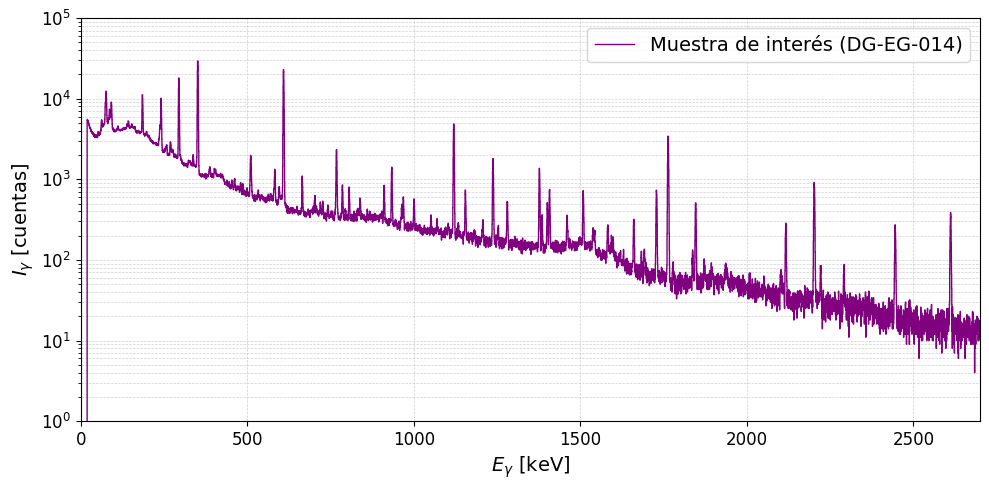

In [190]:
datos = "2021-12-04_mue_DG-EG-014_24h.csv"
df = pd.read_csv(datos)

canal = df.iloc[:, 0]
cuentas = df.iloc[:, 1]

a0 = -1.41     # keV
a1 = 0.48114   # keV/canal

energia = a0 + a1 * canal   # conversión canal → keV


plt.figure(figsize=(10,5))
plt.plot(energia, cuentas, color='purple', ds="steps-mid", lw=1, label='Muestra de interés (DG-EG-014)')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.yscale('log')
plt.xlabel("$E_\gamma$ [keV]", fontsize=14)
plt.ylabel("$I_\\gamma$ [cuentas]", fontsize=14)
plt.grid(which="both", linestyle="--", linewidth=0.5, alpha=0.6)
plt.legend(fontsize=14)
plt.xlim(0,2700)
plt.ylim(1, 1e5)
plt.tight_layout()
plt.show()


Referencias

<>:18: SyntaxWarning: invalid escape sequence '\g'
<>:18: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3448137877.py:18: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("$E_\gamma$ [keV]", fontsize=14)


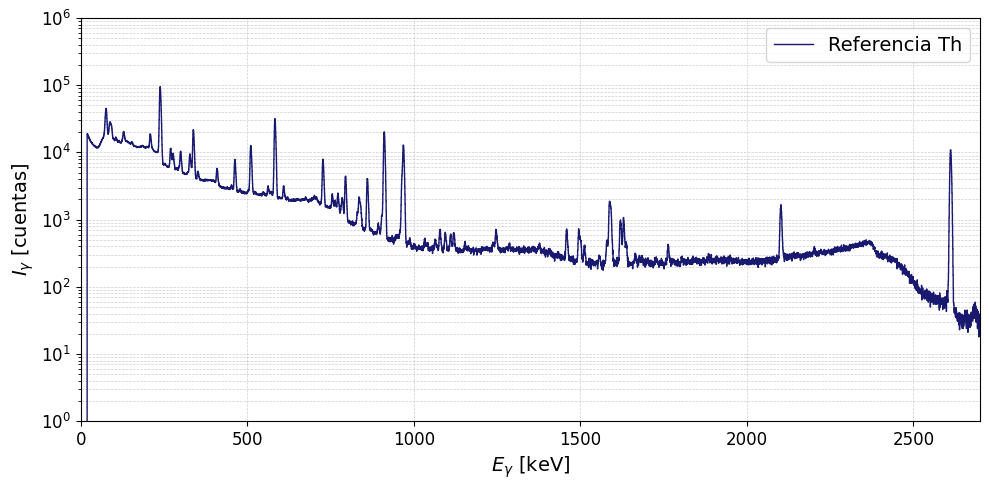

In [204]:
datos = "2021-11-15_mue_IAEA-RGTh-1_24h.csv"
df = pd.read_csv(datos)

canal = df.iloc[:, 0]
cuentas = df.iloc[:, 1]

a0 = -1.41     # keV
a1 = 0.48114   # keV/canal

energia = a0 + a1 * canal   # conversión canal → keV


plt.figure(figsize=(10,5))
plt.plot(energia, cuentas, color='midnightblue', ds="steps-mid", lw=1, label='Referencia Th')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.yscale('log')
plt.xlabel("$E_\gamma$ [keV]", fontsize=14)
plt.ylabel("$I_\\gamma$ [cuentas]", fontsize=14)
plt.grid(which="both", linestyle="--", linewidth=0.5, alpha=0.6)
plt.legend(fontsize=14)
plt.xlim(0,2700)
plt.ylim(1, 1e6)
plt.tight_layout()
plt.show()


<>:18: SyntaxWarning: invalid escape sequence '\g'
<>:18: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3623286005.py:18: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("$E_\gamma$ [keV]", fontsize=14)


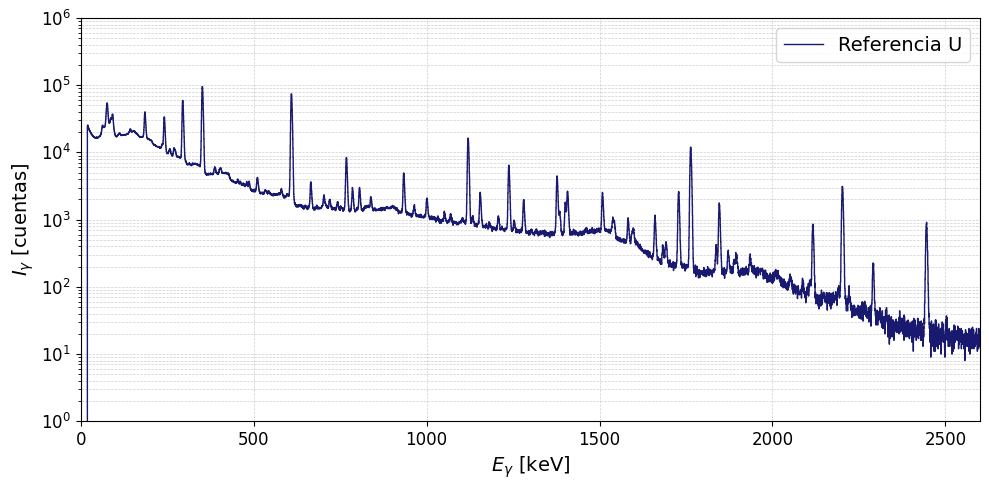

In [209]:
datos = "2021-11-16_mue_IAEA-RGU-1_24h.csv"
df = pd.read_csv(datos)

canal = df.iloc[:, 0]
cuentas = df.iloc[:, 1]

a0 = -1.41     # keV
a1 = 0.48114   # keV/canal

energia = a0 + a1 * canal   # conversión canal → keV


plt.figure(figsize=(10,5))
plt.plot(energia, cuentas, color='midnightblue', ds="steps-mid", lw=1, label='Referencia U')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.yscale('log')
plt.xlabel("$E_\gamma$ [keV]", fontsize=14)
plt.ylabel("$I_\\gamma$ [cuentas]", fontsize=14)
plt.grid(which="both", linestyle="--", linewidth=0.5, alpha=0.6)
plt.legend(fontsize=14)
plt.xlim(0,2600)
plt.ylim(1, 1e6)
plt.tight_layout()
plt.show()


<>:18: SyntaxWarning: invalid escape sequence '\g'
<>:18: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-2113354830.py:18: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("$E_\gamma$ [keV]", fontsize=14)


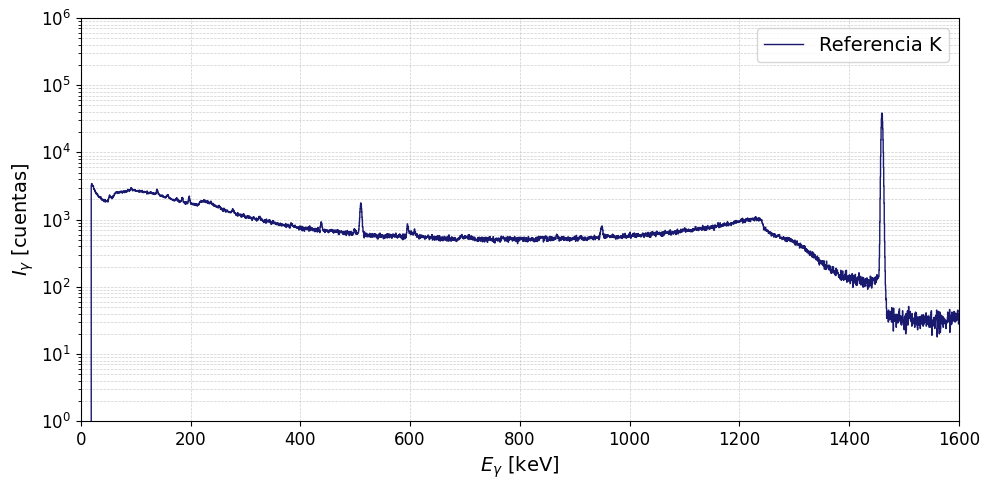

In [218]:
datos = "2021-11-17_mue_IAEA-RGK-1_24h.csv"
df = pd.read_csv(datos)

canal = df.iloc[:, 0]
cuentas = df.iloc[:, 1]

a0 = -1.41     # keV
a1 = 0.48114   # keV/canal

energia = a0 + a1 * canal   # conversión canal → keV


plt.figure(figsize=(10,5))
plt.plot(energia, cuentas, color='midnightblue', ds="steps-mid", lw=1, label='Referencia K')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.yscale('log')
plt.xlabel("$E_\gamma$ [keV]", fontsize=14)
plt.ylabel("$I_\\gamma$ [cuentas]", fontsize=14)
plt.grid(which="both", linestyle="--", linewidth=0.5, alpha=0.6)
plt.legend(fontsize=14)
plt.xlim(0,1600)
plt.ylim(1, 1e6)
plt.tight_layout()
plt.show()
